<h2> Исследование - Определение стоимости автомобилей <a class="tocSkip"> </h2>

Каждый день мы видим, что автомобильный рынок быстро растет, и это приводит нас к ситуации, где многие люди покупают и продают автомобили на рынке, хотелось бы, чтобы этот процесс был более плавным и с лучшим представлением о рынке.

Из-за роста цен на новые автомобили и неспособности клиентов покупать новые автомобили из-за дефицита средств продажи подержанных автомобилей растут во всем мире. Следовательно, существует потребность в системе прогнозирования, которая помогла бы нам определить истинную стоимость автомобиля, эффективно используя множество различных функций. Я попробую создать  модель, которая будет использовать конкретную информацию, связанную с автомобилем, и предсказывать цену продажи. Это поможет получить лучший обзор при покупке и продаже автомобилей.

В данном примере есть сервис по продаже автомобилей с пробегом, он разрабатывает приложение, чтобы привлечь новых клиентов. В нём можно будет узнать рыночную стоимость своего автомобиля. 


<h2> Цель работы <a class="tocSkip"> </h2>
    
Построить модель, которая умеет узнать рыночную стоимость своего автомобиля. В нашем распоряжении данные о технических характеристиках, комплектации и ценах других автомобилей.
    
Критерии, которые важны заказчику:
- качество предсказания;
- время обучения модели;
- время предсказания модели.
    
<h2> Основные шаги <a class="tocSkip"> </h2>

 - Загрузить данные
 - Изучить данные
 - Заполните пропущенные значения и обработать аномалии в столбцах. Если среди признаков имеются неинформативные, удалим их.
 - Подготовьть выборки для обучения моделей.
 - Обучить разные модели, одна из которых — LightGBM, как минимум одна — не бустинг. Для каждой модели попробуем разные гиперпараметры.
 - Проанализировать время обучения, время предсказания и качество моделей.
 - Опираясь на критерии заказчика, выберем лучшую модель, проверим её качество на тестовой выборке.
 - Общий вывод

    Примечания:
- Для оценки качества моделей применим метрику RMSE.
- Значение метрики RMSE должно быть меньше 2500.
    
<h2> Описание данных <a class="tocSkip"> </h2>

Данные находятся в файле autos.csv.

    Признаки:
- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- Repaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

   Целевой признак:
- Price — цена (евро)

## Изучение данных 

###  Загрузка данных

In [76]:
pip install catboost -q

In [77]:
pip install phik -q

In [78]:
pip install skimpy -q

In [79]:
!pip install lightgbm -q

In [81]:
# Импоритруем библиотеки 

import warnings
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats as st
from skimpy import clean_columns
import phik
import time



import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.dummy import DummyRegressor



from sklearn.model_selection import (
    GridSearchCV,
    train_test_split,
    cross_val_score
) 

from sklearn.metrics import mean_squared_error
from math import sqrt


from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler
)

warnings.filterwarnings("ignore")

In [82]:
# Прочитаем файл и запишем в переменную df
# Используем метод Tru - Except для стабильного подключения, в случаее если первый вариант пути будет не обнаружен.

try:
    df = pd.read_csv('/Users/ilyashirikov/Downloads/autos.csv')
except:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/autos.csv')

### Изучаем данные

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06


,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


None

array([[<Axes: title={'center': 'Price'}>,
        <Axes: title={'center': 'RegistrationYear'}>,
        <Axes: title={'center': 'Power'}>],
       [<Axes: title={'center': 'Kilometer'}>,
        <Axes: title={'center': 'RegistrationMonth'}>,
        <Axes: title={'center': 'NumberOfPictures'}>],
       [<Axes: title={'center': 'PostalCode'}>, <Axes: >, <Axes: >]],
      dtype=object)

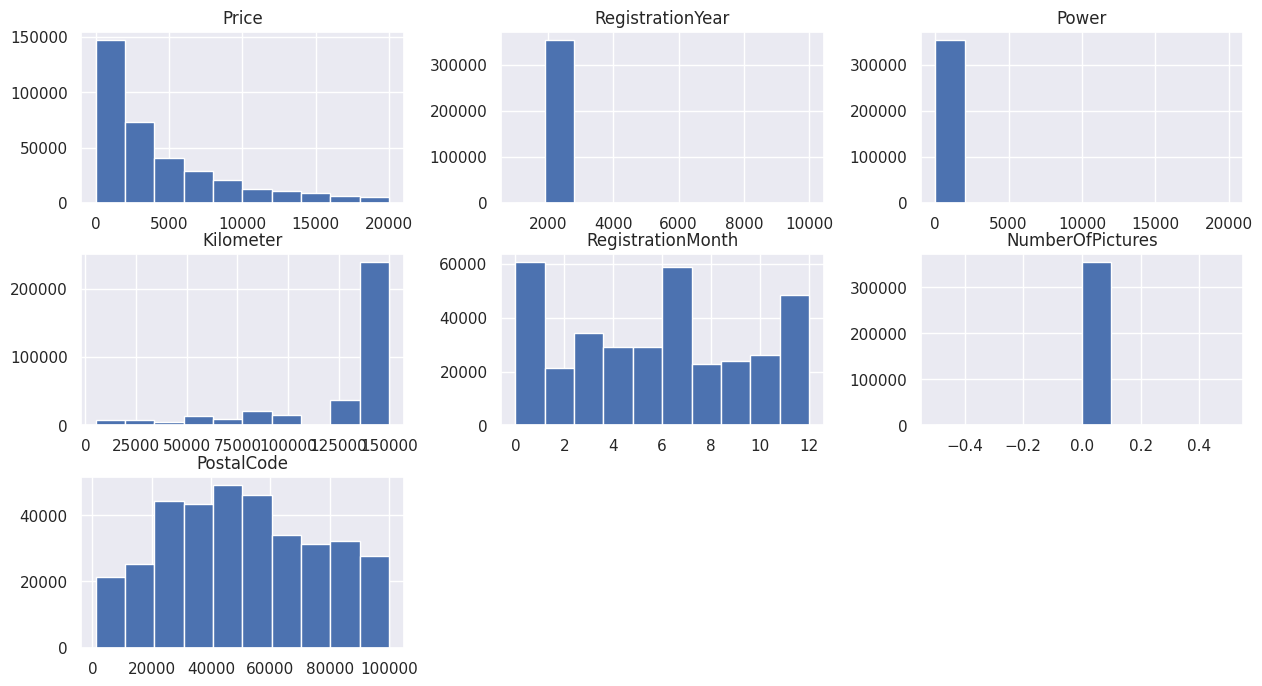

In [83]:
# Создадим функцию fanc() для вывода всех необходимых методов показа информации df

def info_func(i):
    info = display(i.head(10), i.describe(), i.info(), i.hist())

info_func(df)


In [84]:
# Приводим название столбцов к нижнему регистру

#df.columns = map(str.lower, df.columns)
df = clean_columns(df)

16 column names have been cleaned

In [85]:
# Посмотрим какой тип задаст автоматический convert_dtypes и посомтрим пропуски 

def search_func(i):
    search = display(i.convert_dtypes().info(), i.isna().sum())

search_func(df)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   date_crawled        354369 non-null  string
 1   price               354369 non-null  Int64 
 2   vehicle_type        316879 non-null  string
 3   registration_year   354369 non-null  Int64 
 4   gearbox             334536 non-null  string
 5   power               354369 non-null  Int64 
 6   model               334664 non-null  string
 7   kilometer           354369 non-null  Int64 
 8   registration_month  354369 non-null  Int64 
 9   fuel_type           321474 non-null  string
 10  brand               354369 non-null  string
 11  repaired            283215 non-null  string
 12  date_created        354369 non-null  string
 13  number_of_pictures  354369 non-null  Int64 
 14  postal_code         354369 non-null  Int64 
 15  last_seen           354369 non-null  string
dtypes:

None

date_crawled              0
price                     0
vehicle_type          37490
registration_year         0
gearbox               19833
power                     0
model                 19705
kilometer                 0
registration_month        0
fuel_type             32895
brand                     0
repaired              71154
date_created              0
number_of_pictures        0
postal_code               0
last_seen                 0
dtype: int64

### Краткий вывод 

Загрузив и изучив данные можно сказать что, мы имеем 354 тысячи строк данных, где есть 15 признаков.Не все признаки нам нужны, не информативные признаки удалим.

В пяти столбцах есть серьезное количество пропусков, необходимо понять почему они появились и как востановить данные.

В столбцах где нет пропусков можно наблюдать выбросы, я это видно от части по гистограмме.

## Обработка значений и анамалий в столбцах

Считаю что признаки с датами никак не влияют на цену кроме даты регистрации авто, тут можно считать что это почти как дата выпуска автомобиля, кол-во фото так же не влияет на цену, вполне возможно что фото может влиять на скорость продажи авто, признак 'brand' удалили по причине сильной корреляции с признаком "model", корреляция ровна 1 , смысл его оставлять нет.

In [86]:
# Решил удалить не нужные признаки 

df = df.drop(['date_crawled',
              'date_created',
              'last_seen',
              'number_of_pictures',
              'postal_code', 'brand'], axis=1).reset_index(drop= True)


interval columns not set, guessing: ['price', 'registration_year', 'power', 'kilometer', 'registration_month']


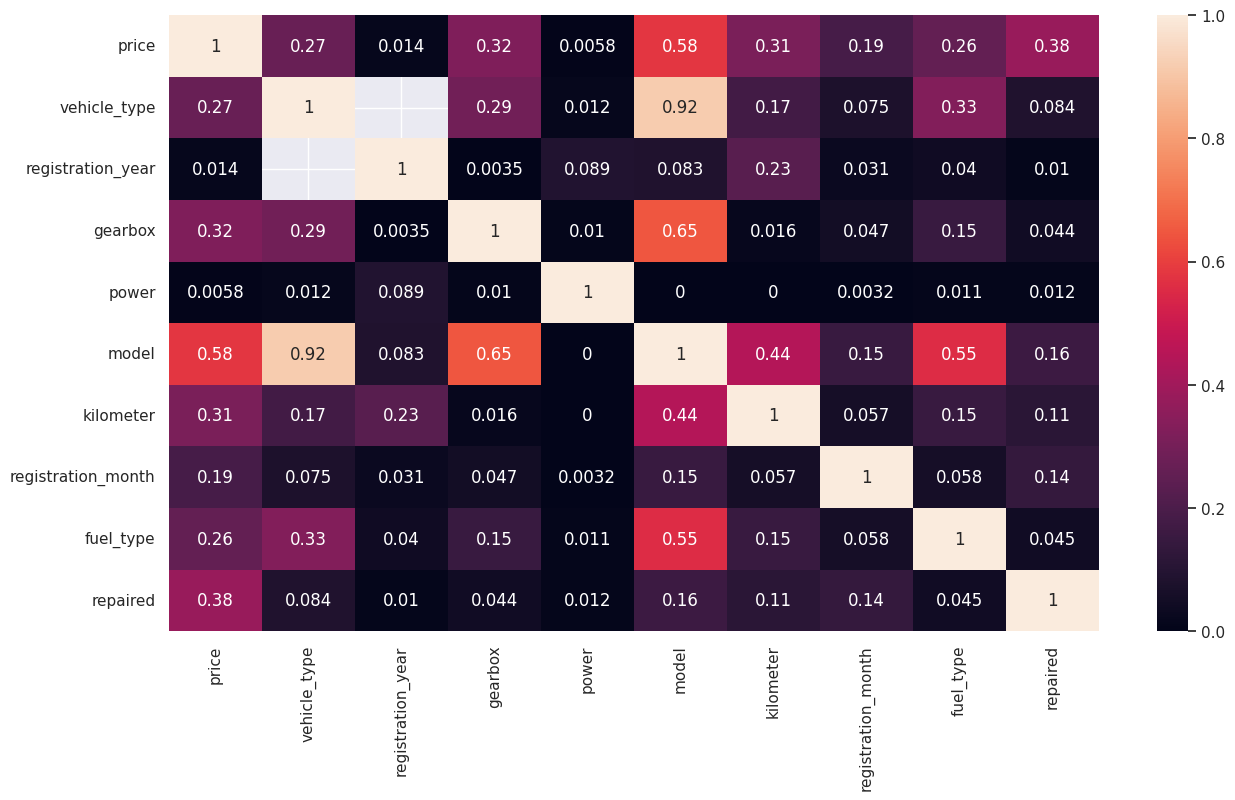

In [87]:
# После удаления не нужных признаков можно глянуть что у нас по корреляции поможет нам в этом phik


sns.set(rc = {'figure.figsize':(15,8)})
sns.heatmap(df.phik_matrix(), annot=True);

Можно наблюдать зависимость признаков, по этой зависимости будеи и заполнять пропуски, на основе бренда заполню пропуски модели, далее на основе модели буду заполнять пропуски других значений, бренд думаю удалить тк корреляция 1 с моделью, посути бренд будет лишний.

Далее разберу каждый признак, проверю выбросы и заполню пропуски 

In [88]:
def processing_func(i):
    print("Кол-во дубликатов =", i.duplicated().sum())
    print()
    print('Уникальные значения -',i.unique())
    print()
    print('Сумма уникальных значений =',i.nunique())
    print()
    print('Описательная статистика')
    print()
    print(i.describe())

Кол-во дубликатов = 354118

Уникальные значения - ['golf' nan 'grand' 'fabia' '3er' '2_reihe' 'other' 'c_max' '3_reihe'
 'passat' 'navara' 'ka' 'polo' 'twingo' 'a_klasse' 'scirocco' '5er'
 'meriva' 'arosa' 'c4' 'civic' 'transporter' 'punto' 'e_klasse' 'clio'
 'kadett' 'kangoo' 'corsa' 'one' 'fortwo' '1er' 'b_klasse' 'signum'
 'astra' 'a8' 'jetta' 'fiesta' 'c_klasse' 'micra' 'vito' 'sprinter' '156'
 'escort' 'forester' 'xc_reihe' 'scenic' 'a4' 'a1' 'insignia' 'combo'
 'focus' 'tt' 'a6' 'jazz' 'omega' 'slk' '7er' '80' '147' '100' 'z_reihe'
 'sportage' 'sorento' 'v40' 'ibiza' 'mustang' 'eos' 'touran' 'getz' 'a3'
 'almera' 'megane' 'lupo' 'r19' 'zafira' 'caddy' 'mondeo' 'cordoba' 'colt'
 'impreza' 'vectra' 'berlingo' 'tiguan' 'i_reihe' 'espace' 'sharan'
 '6_reihe' 'panda' 'up' 'seicento' 'ceed' '5_reihe' 'yeti' 'octavia' 'mii'
 'rx_reihe' '6er' 'modus' 'fox' 'matiz' 'beetle' 'c1' 'rio' 'touareg'
 'logan' 'spider' 'cuore' 's_max' 'a2' 'galaxy' 'c3' 'viano' 's_klasse'
 '1_reihe' 'avensis' 'r

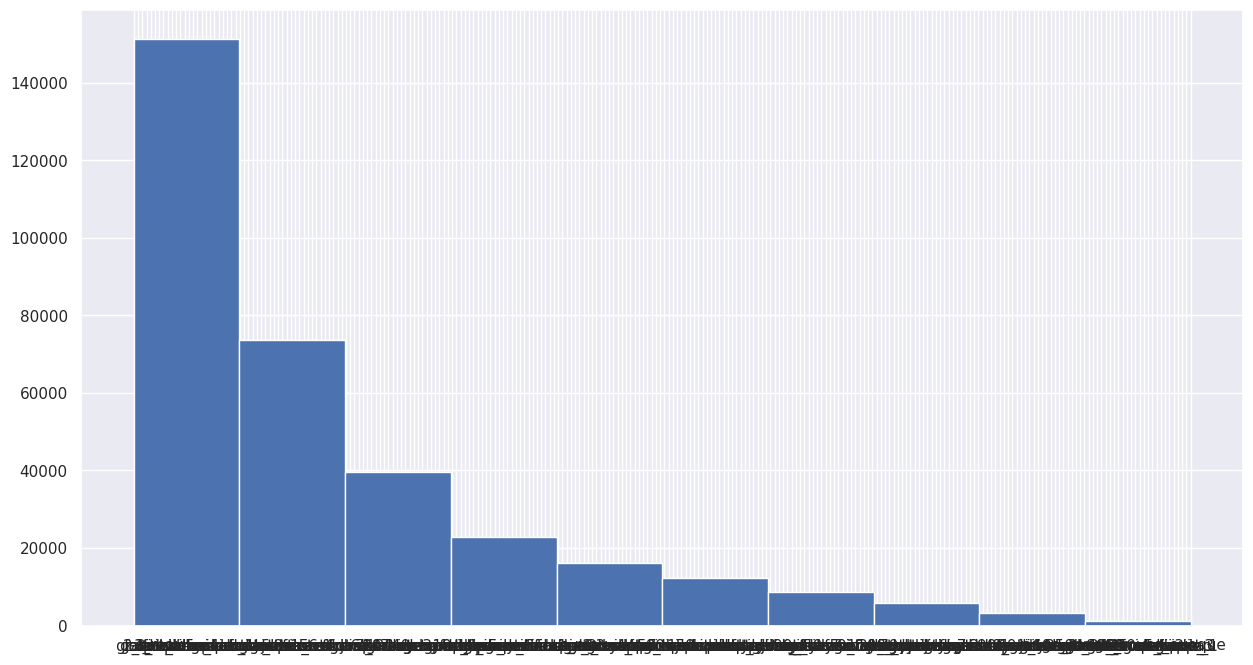

In [89]:
# Обработка признака Модель

processing_func(df['model'])
df['model'].hist()
print()
print("Кол-во пропусков =",df['model'].isna().sum())

In [90]:
# Модель это основопологающий фактор, который на прямую воздействует на образование цены 
# и заменить его на что-либо другое будет неправильно, к сожалению их нельзя восстановит по Brand придется удалить

df.dropna(subset=['model'], inplace=True)

Кол-во дубликатов = 330994

Уникальные значения - [  480  9800  1500 ... 12395 18429 10985]

Сумма уникальных значений = 3670

Описательная статистика

count    334664.000000
mean       4504.346790
std        4531.438572
min           0.000000
25%        1150.000000
50%        2800.000000
75%        6500.000000
max       20000.000000
Name: price, dtype: float64


<Axes: >

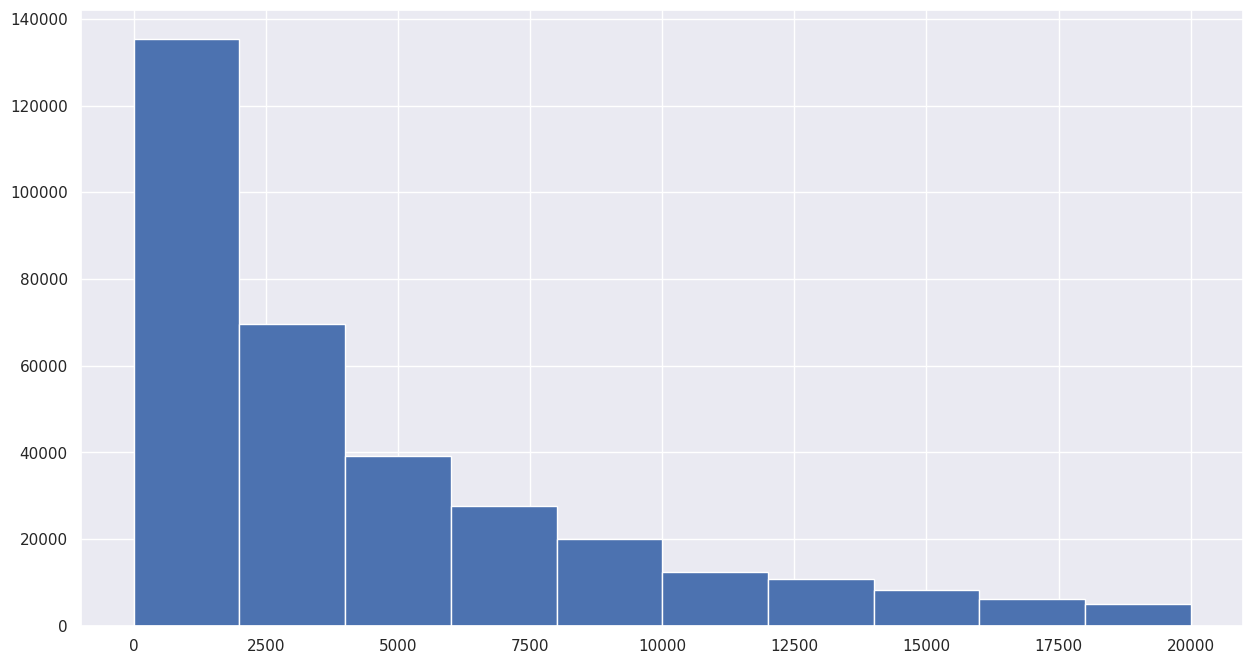

In [91]:
# Обработка признака Цена

processing_func(df['price'])
df['price'].hist()

In [92]:
# посмотрим сколько цена машин ниже 100 евро
(df['price'] < 100).value_counts()


False    324022
True      10642
Name: price, dtype: int64

In [93]:
# Видим что порядка 10 тыс машин ценой ниже 100 евро и по описательной статистике можно заметить что
# минимальное значение = 0. Принимаю решение что все что ниже цены 100 евро это выбросы и удаляю их.

df = df.query('price > 100')

Кол-во дубликатов = 323126

Уникальные значения - [nan 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' 'coupe' 'other']

Сумма уникальных значений = 8

Описательная статистика

count     296068
unique         8
top        sedan
freq       85958
Name: vehicle_type, dtype: object

Кол-во пропусков = 27067


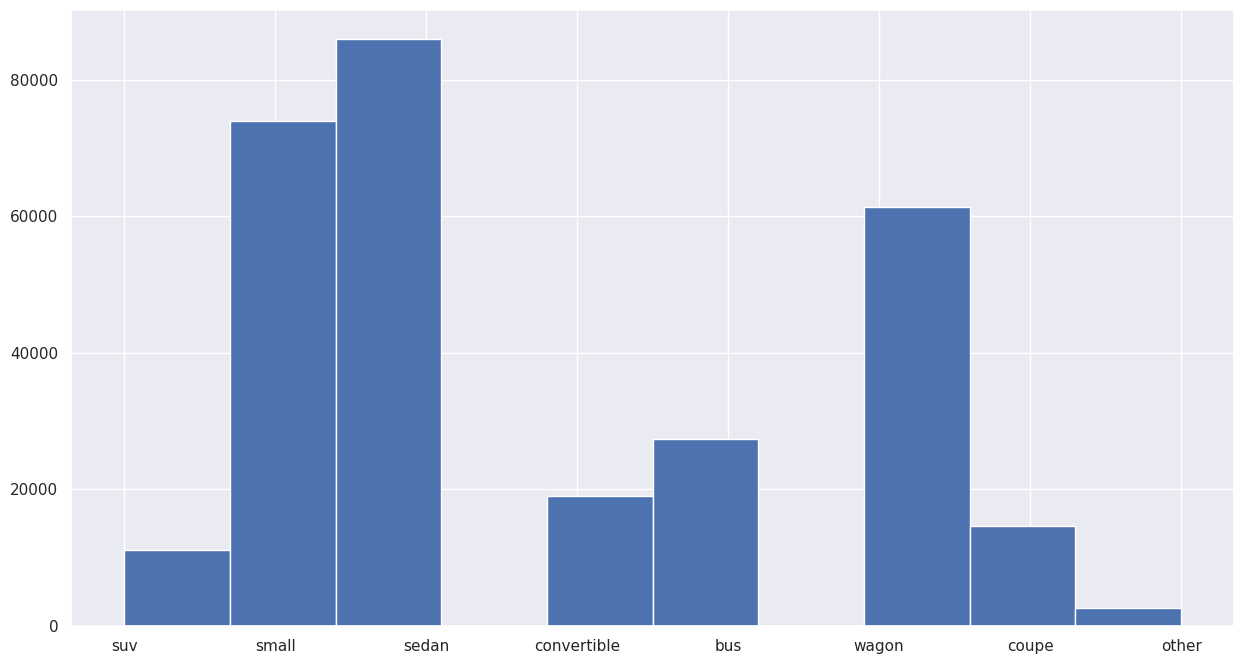

In [94]:
# Обработка признака тип автомобильного кузова

processing_func(df['vehicle_type'])
df['vehicle_type'].hist()
print()
print("Кол-во пропусков =",df['vehicle_type'].isna().sum())

In [95]:
# Колличество пропусков в VehicleType около 10 процентов, 
# данных слишком много чтобы просто от них избавится, 
# если заменить на среднюю это тоже может сказаться на точности предсказания. 
# Если брать в расчет что в дальнейшем пользователи при оценке автомобиля могут так же не вводить тип кузова, 
# то стоит заменить пропущенные значения на other

#df['vehicle_type'] = df['vehicle_type'].fillna('unknown')

df['vehicle_type'] = df['vehicle_type'].fillna(df
                                       .groupby('model')['vehicle_type']
                                       .transform(lambda x: x.value_counts().idxmax())
                                    )

Кол-во дубликатов = 323015

Уникальные значения - [1993 2004 2001 2008 1995 2014 1998 2005 2011 1910 2016 2007 2009 2002
 2018 1997 1990 2017 1981 2003 1994 1991 1984 2006 1999 2012 2010 2000
 1992 2013 1996 1985 1989 2015 1982 1976 1983 1973 1969 1971 1987 1986
 1988 1980 1965 1970 1945 1974 1955 1978 1979 1972 1968 1977 1966 1975
 1963 1960 1961 1967 1000 9999 1500 2200 1964 3000 2066 1949 2019 1937
 1951 1959 1953 1954 1958 1956 1962 9000 2900 5900 5911 1400 5000 1950
 4000 1952 8500 1932 3700 1942 1933 1936 1957 1923 2290 1930 1001 1234
 7000 1929 1943 1938 1934 1935 1928 1941 5555 1800 6000 1300 1931 4500
 1602 7800 1947 1927 7100 8200 2500 1600]

Сумма уникальных значений = 120

Описательная статистика

count    323135.000000
mean       2003.803104
std          55.795947
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
Name: registration_year, dtype: float64

Кол-во пропусков = 0


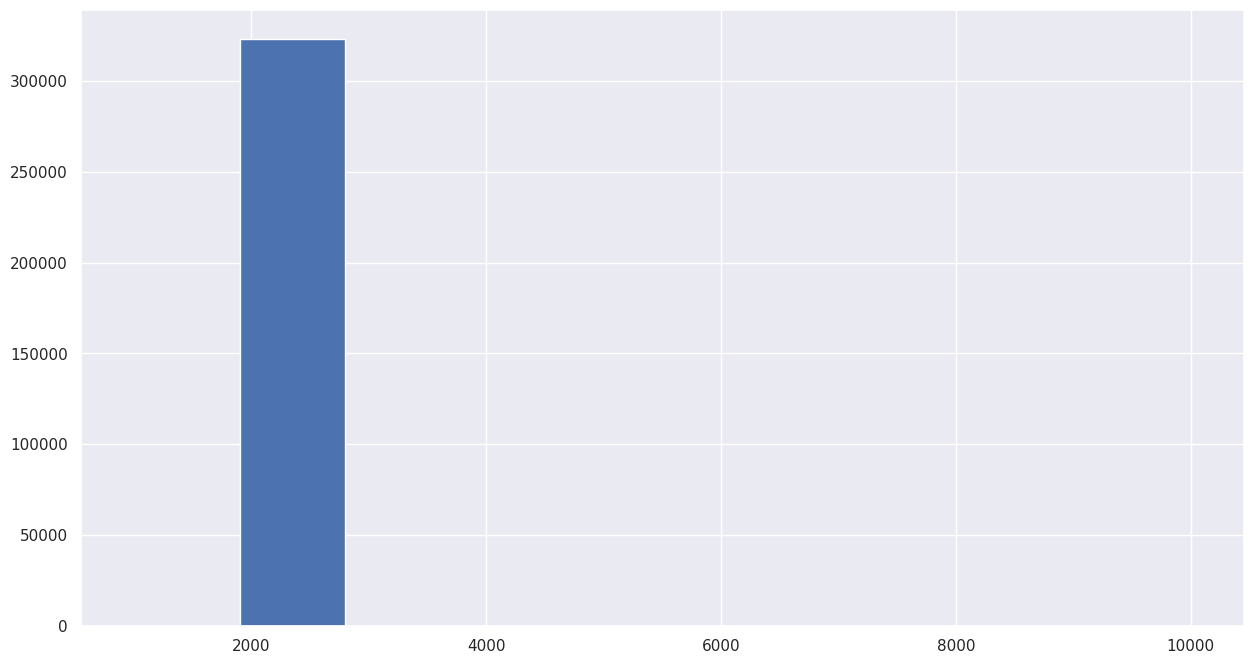

In [96]:
# Обработка признака год регистрации автомобиля

processing_func(df['registration_year'])
df['registration_year'].hist()
print()
print("Кол-во пропусков =",df['registration_year'].isna().sum())

In [97]:
# Посмотрим на года в отсортированом виде

sorted(df.registration_year.unique())

[1000,
 1001,
 1234,
 1300,
 1400,
 1500,
 1600,
 1602,
 1800,
 1910,
 1923,
 1927,
 1928,
 1929,
 1930,
 1931,
 1932,
 1933,
 1934,
 1935,
 1936,
 1937,
 1938,
 1941,
 1942,
 1943,
 1945,
 1947,
 1949,
 1950,
 1951,
 1952,
 1953,
 1954,
 1955,
 1956,
 1957,
 1958,
 1959,
 1960,
 1961,
 1962,
 1963,
 1964,
 1965,
 1966,
 1967,
 1968,
 1969,
 1970,
 1971,
 1972,
 1973,
 1974,
 1975,
 1976,
 1977,
 1978,
 1979,
 1980,
 1981,
 1982,
 1983,
 1984,
 1985,
 1986,
 1987,
 1988,
 1989,
 1990,
 1991,
 1992,
 1993,
 1994,
 1995,
 1996,
 1997,
 1998,
 1999,
 2000,
 2001,
 2002,
 2003,
 2004,
 2005,
 2006,
 2007,
 2008,
 2009,
 2010,
 2011,
 2012,
 2013,
 2014,
 2015,
 2016,
 2017,
 2018,
 2019,
 2066,
 2200,
 2290,
 2500,
 2900,
 3000,
 3700,
 4000,
 4500,
 5000,
 5555,
 5900,
 5911,
 6000,
 7000,
 7100,
 7800,
 8200,
 8500,
 9000,
 9999]

In [98]:
# Есть обявления которые были созданы 2016 г, когда в таких обьявлениях есть
# машины 2019 г, это странно
# Видим что есть не коректные года принимаю диапозон от 1960 по 2016 год

df = df.query('1960 < registration_year < 2016')

Кол-во дубликатов = 303467

Уникальные значения - ['manual' 'auto' nan]

Сумма уникальных значений = 2

Описательная статистика

count     292480
unique         2
top       manual
freq      233259
Name: gearbox, dtype: object

Кол-во пропусков = 10990


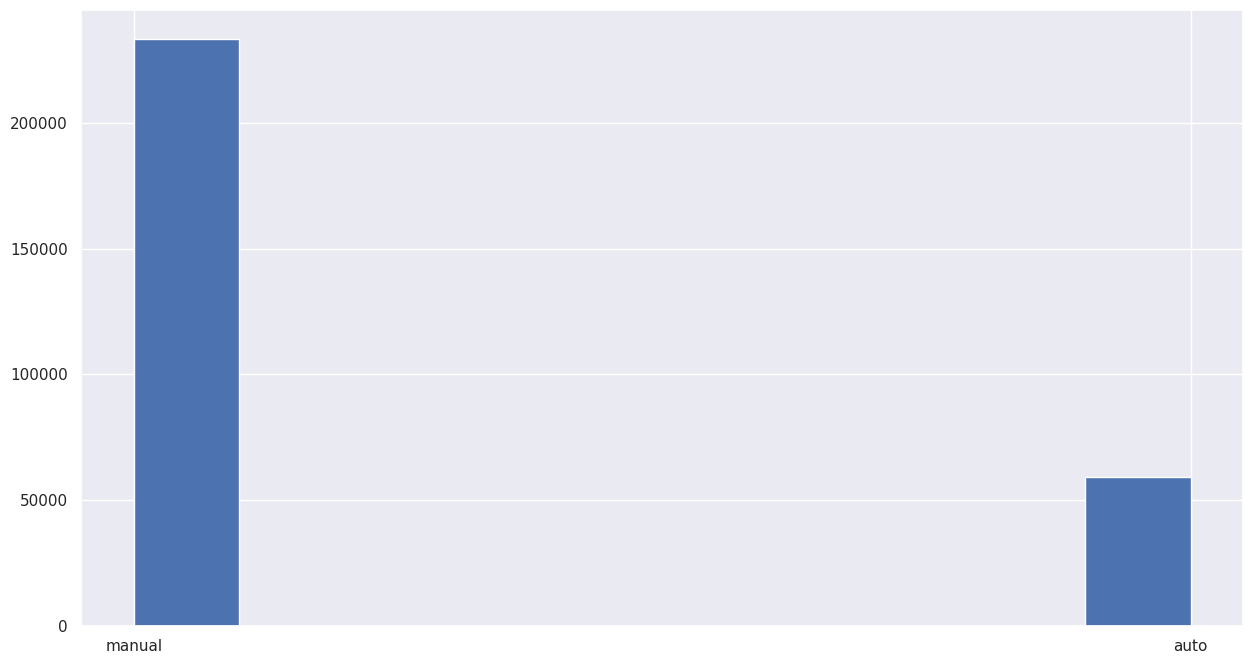

In [99]:
# Обработка признака тип коробки передач

processing_func(df['gearbox'])
df['gearbox'].hist()
print()
print("Кол-во пропусков =",df['gearbox'].isna().sum())

In [100]:
# Есть значения power равные 0 и больше 1000 что являеться некорректным, можно заменить их на медиану по модели

df['gearbox'] = df['gearbox'].fillna(df
                                       .groupby('model')['gearbox']
                                       .transform(lambda x: x.value_counts().idxmax())
                                    )

Кол-во дубликатов = 302829

Уникальные значения - [    0   163    75    69   102   109   125   101   105   140   115   131
   190   136   160   231    50   118   193    99    60   113   218   122
   129    70   306    95    61   177   170   143   232   150   156    80
    82    90   155   185    87   180    86    84   224   235   200   178
   265    77   110   144   120    54   286   116   184   126   204    88
   194    64   305   197   179   250   313    41    45   165    98   130
   114   211    56   201   213    58   107   174   100   220    73   192
    66   299    74    52   147    71    97    65   239    68   203   300
   103    85   258   320    63    81   148    44    83   145    55   280
   260   104   188   333   117   141   132   234   158    39    92    51
   135   230   209    43   146    67   106   166   276   344    72   237
   245   111   326   279    23   138   310   175    96   226   301   334
   128   133   124    33   219   241   167   182   196   238  1398   228
 

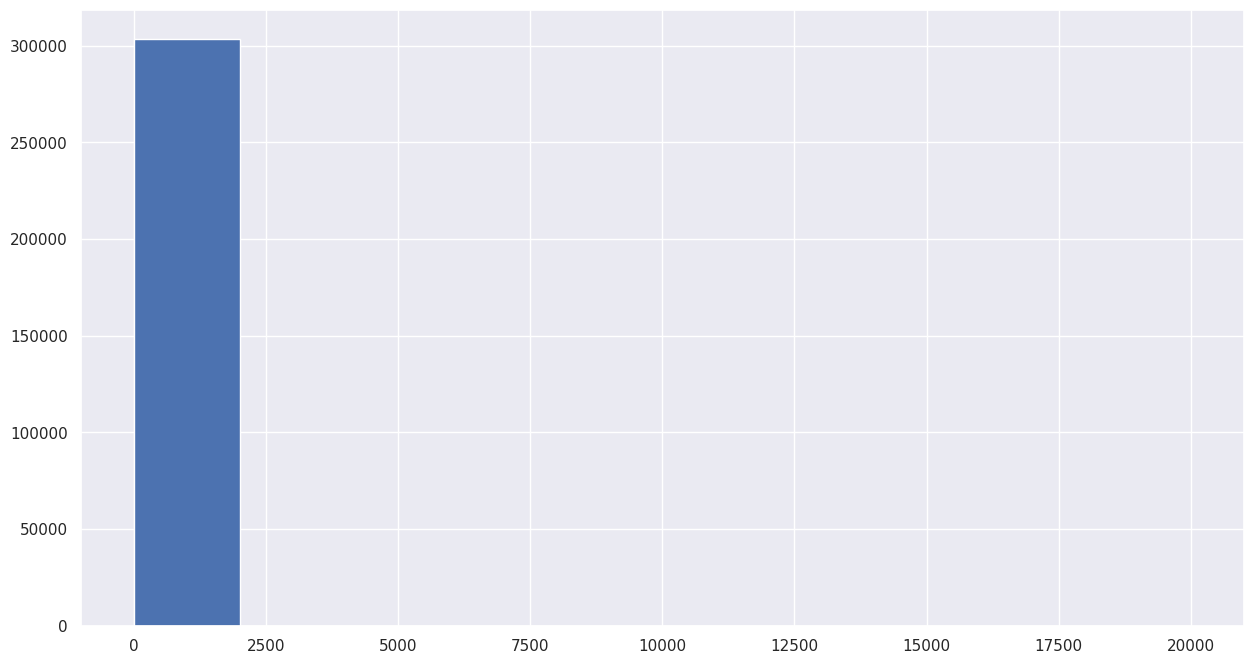

In [101]:
# Обработка признака мощность (л. с.)

processing_func(df['power'])
df['power'].hist()
print()
print("Кол-во пропусков =",df['power'].isna().sum())

In [102]:
df.loc[(df['power'] > 1000) | (df['power'] <= 30), 'power'] = None
df['power'] = df['power'].fillna(df.groupby('model')['power'].transform('median'))
df = df.loc[~df['power'].isna()]
df['power'] = df['power'].astype('int64')

Кол-во дубликатов = 303456

Уникальные значения - [150000 125000  90000  30000  70000 100000  60000   5000  20000  80000
  50000  40000  10000]

Сумма уникальных значений = 13

Описательная статистика

count    303469.000000
mean     128417.828510
std       36801.859429
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: kilometer, dtype: float64

Кол-во пропусков = 0


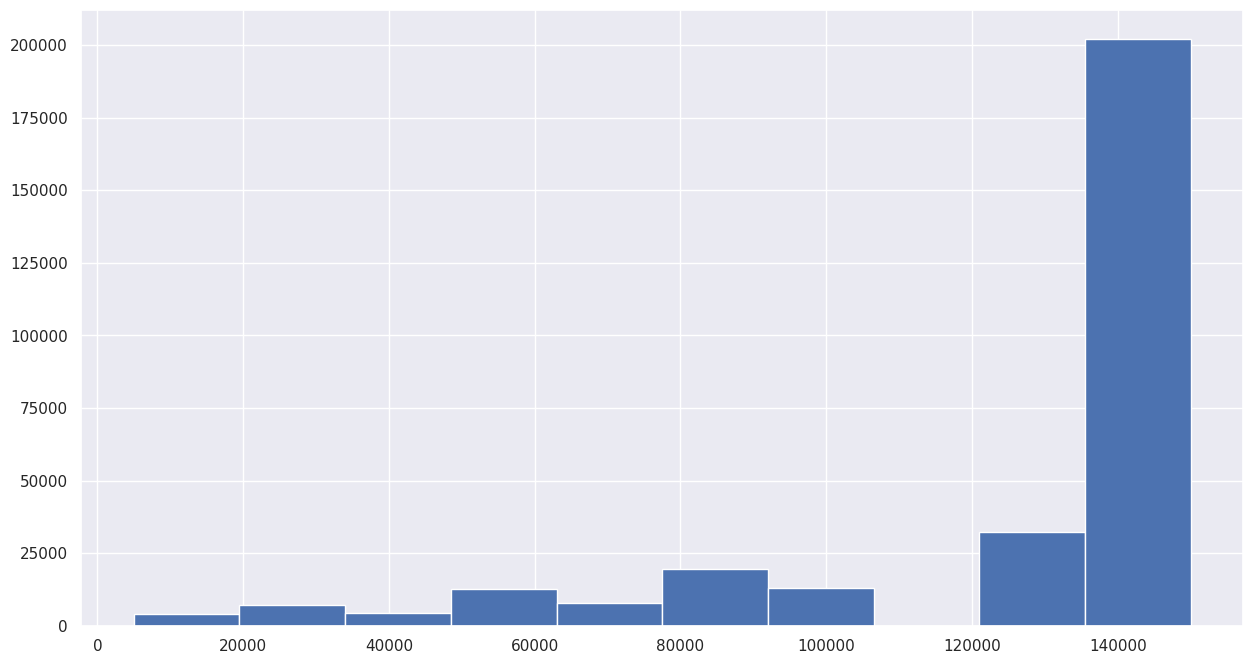

In [103]:
# Обработка признака пробег (км)

processing_func(df['kilometer'])
df['kilometer'].hist()
print()
print("Кол-во пропусков =",df['kilometer'].isna().sum())

C kilometer обсолютно все впорядке идем дальше 

Кол-во дубликатов = 303461

Уникальные значения - ['petrol' 'gasoline' nan 'lpg' 'other' 'hybrid' 'cng' 'electric']

Сумма уникальных значений = 7

Описательная статистика

count     288026
unique         7
top       petrol
freq      191380
Name: fuel_type, dtype: object

Кол-во пропусков = 15443


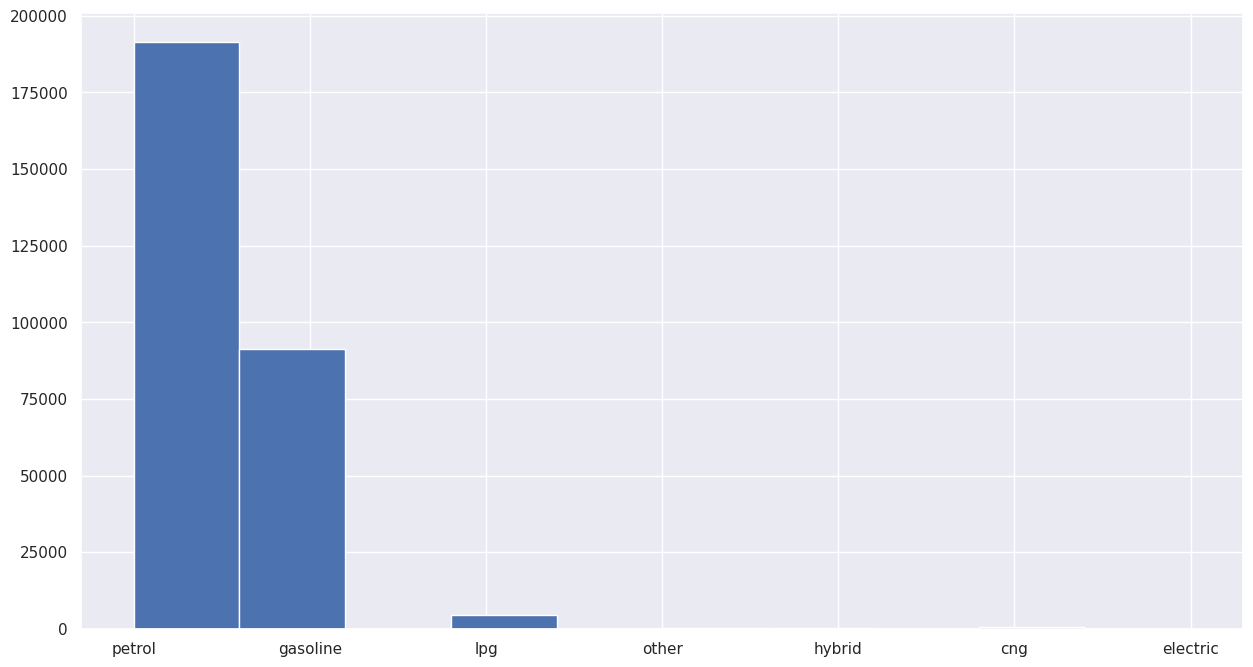

In [104]:
# Обработка признака тип топлива

processing_func(df['fuel_type'])
df['fuel_type'].hist()
print()
print("Кол-во пропусков =",df['fuel_type'].isna().sum())

In [105]:
# Пропуски в fuel_type заменю на среднее по моделям

df['fuel_type'] = df['fuel_type'].fillna(df
                                         .groupby('model')['fuel_type']
                                         .transform(lambda x: x.value_counts().idxmax())
                                        )


Кол-во дубликатов = 303466

Уникальные значения - [nan 'no' 'yes']

Сумма уникальных значений = 2

Описательная статистика

count     255248
unique         2
top           no
freq      226080
Name: repaired, dtype: object

Кол-во пропусков = 48221


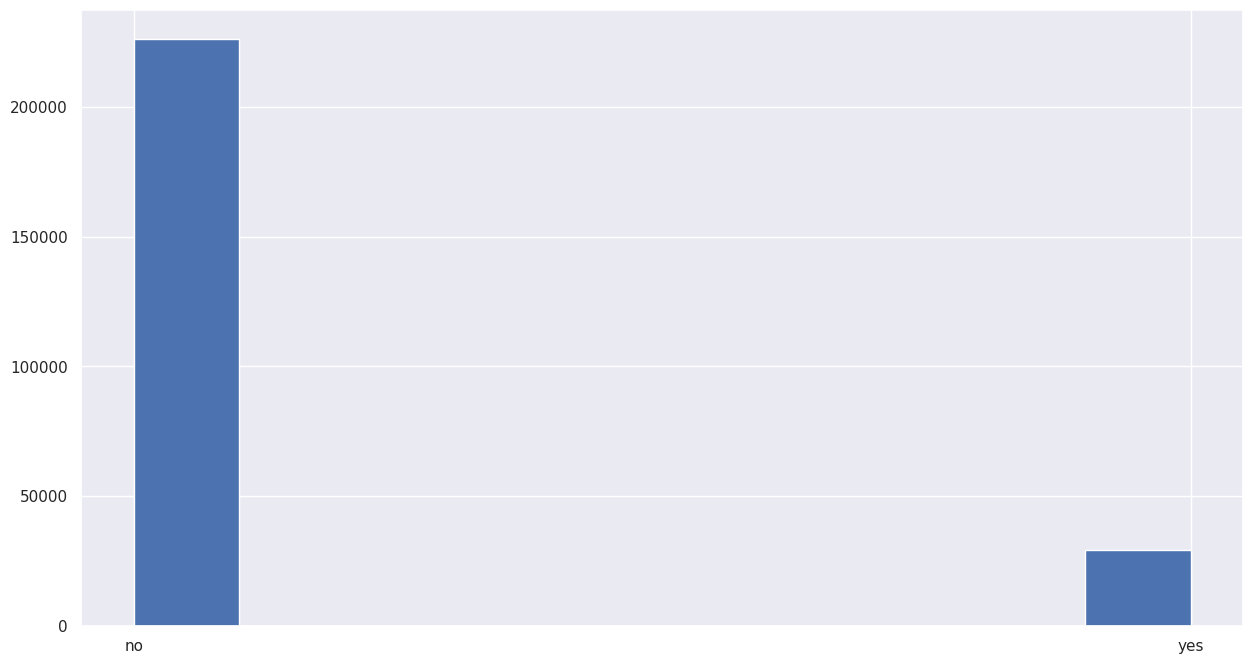

In [106]:
# Обработка признака была машина в ремонте или нет
# На самом деле признак спорный, изначально думал удалить, очень уж сильно он влияет на цену 
# и нет у нас доп ресурсов что бы востановить пропуски 

processing_func(df['repaired'])
df['repaired'].hist()
print()
print("Кол-во пропусков =",df['repaired'].isna().sum())

In [107]:
# Пропусков в этом признаке очень много, логика тут простая, 
# если не указали что машина ремонтировалась, значит ремонт был 
# Заменю пропуски значением Yes
# Хотя я знаю что решение спорное и вызовет шум 

df["repaired"].fillna("yes", inplace=True)


In [108]:
# Удалим дубликаты 
df = df.drop_duplicates()

# Скинем индексы 
df = df.reset_index(drop=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 276761 entries, 0 to 276760
Data columns (total 10 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   price               276761 non-null  int64 
 1   vehicle_type        276761 non-null  object
 2   registration_year   276761 non-null  int64 
 3   gearbox             276761 non-null  object
 4   power               276761 non-null  int64 
 5   model               276761 non-null  object
 6   kilometer           276761 non-null  int64 
 7   registration_month  276761 non-null  int64 
 8   fuel_type           276761 non-null  object
 9   repaired            276761 non-null  object
dtypes: int64(5), object(5)
memory usage: 21.1+ MB


,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,repaired
0,480,sedan,1993,manual,101,golf,150000,0,petrol,yes
1,9800,suv,2004,auto,163,grand,125000,8,gasoline,yes
2,1500,small,2001,manual,75,golf,150000,6,petrol,no
3,3600,small,2008,manual,69,fabia,90000,7,gasoline,no
4,650,sedan,1995,manual,102,3er,150000,10,petrol,yes
5,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,no
6,14500,bus,2014,manual,125,c_max,30000,8,petrol,yes
7,999,small,1998,manual,101,golf,150000,0,petrol,yes
8,2000,sedan,2004,manual,105,3_reihe,150000,12,petrol,no
9,2799,wagon,2005,manual,140,passat,150000,12,gasoline,yes


,price,registration_year,power,kilometer,registration_month
count,276761.000000,276761.000000,276761.000000,276761.000000,276761.000000
mean,4776.835717,2002.434089,120.458536,128216.620116,5.925336
std,4584.413354,6.209239,53.258655,36959.851109,3.621736
min,101.000000,1961.000000,31.000000,5000.000000,0.000000
25%,1300.000000,1999.000000,80.000000,125000.000000,3.000000
50%,3000.000000,2003.000000,113.000000,150000.000000,6.000000
75%,6900.000000,2007.000000,150.000000,150000.000000,9.000000
max,20000.000000,2015.000000,1000.000000,150000.000000,12.000000


None

array([[<Axes: title={'center': 'price'}>,
        <Axes: title={'center': 'registration_year'}>],
       [<Axes: title={'center': 'power'}>,
        <Axes: title={'center': 'kilometer'}>],
       [<Axes: title={'center': 'registration_month'}>, <Axes: >]],
      dtype=object)

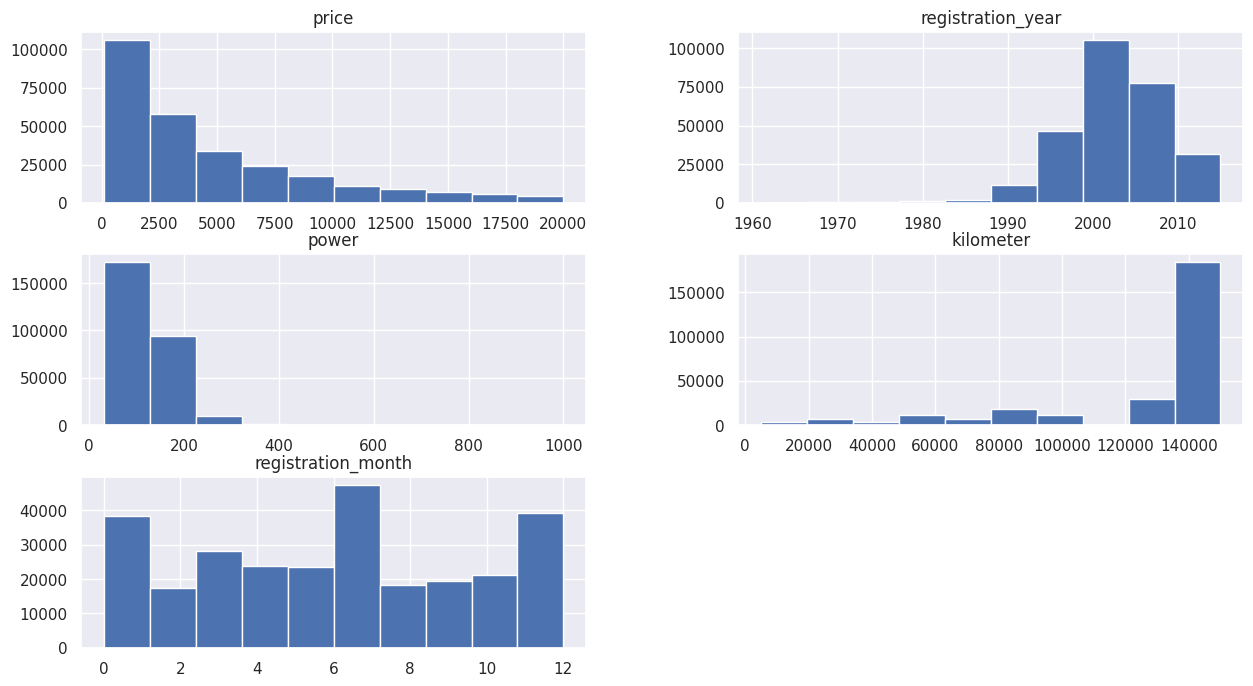

In [109]:
info_func(df)

interval columns not set, guessing: ['price', 'registration_year', 'power', 'kilometer', 'registration_month']


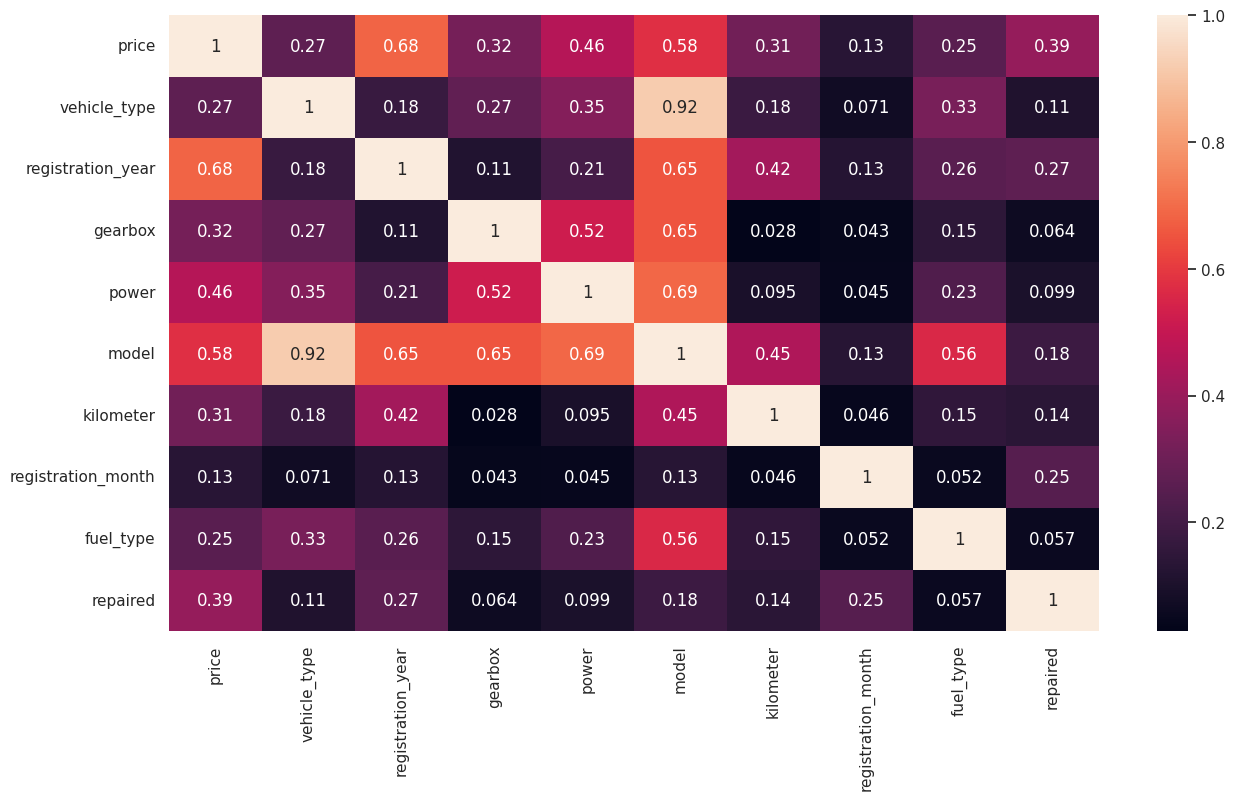

In [110]:
sns.set(rc = {'figure.figsize':(15,8)})
sns.heatmap(df.phik_matrix(), annot=True);

### Краткий вывод 

Провели обработку данных и убрали выбрасы. Было отсеяно порядка 27% данных.

Провели корреляцию и на основе этого были заменены пропуски, отсеяли выбросы и осталось подготовить данные для обучения модели.

## Подготовка выборки для обучения моделей

Данные готовы, осталось рабить их на три выборки train, valid и test.
Для модели LinearRegression проведем кадировку данных с помощью OneHotEncoder.

In [111]:
# Извлекаем целевой признак в переменную target, остальные данные в переменную features

features = df.drop('price', axis=1)
target = df['price']

# Разбиваем исходные данные на обучающую, валидационную и тестовую выборки.

features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.4, random_state=12345)

features_valid, features_test, target_valid, target_test = train_test_split(
    features_valid, target_valid, test_size=0.5, random_state=12345)

# Посмотрим на размеры 

features_train.shape, features_valid.shape, features_test.shape

((166056, 9), (55352, 9), (55353, 9))

In [112]:

# Стандартизируем обучающую и тестовую выборку 
# Избавляемся от категориальных признаков методом One hot encoder
ohe = OneHotEncoder(drop='first', sparse=False, handle_unknown='infrequent_if_exist')

#категориальные признаки для OHE 
ohe_features_train = features_train.select_dtypes(include='object').columns.to_list() 
ohe_features_valid = features_valid.select_dtypes(include='object').columns.to_list()
ohe_features_test = features_test.select_dtypes(include='object').columns.to_list()

#численные признаки
num_features_train = features_train.select_dtypes(exclude='object').columns.to_list()
num_features_valid = features_valid.select_dtypes(exclude='object').columns.to_list()
num_features_test = features_test.select_dtypes(exclude='object').columns.to_list()

# обучаем энкодер на заданных категориальных признаках тренировочной выборки
ohe.fit(features_train[ohe_features_train])

# encoder_ohe.get_feature_names_out() позволяет получить названия колонок
features_train[
    ohe.get_feature_names_out()
] = ohe.transform(features_train[ohe_features_train])

features_valid[
    ohe.get_feature_names_out()
] = ohe.transform(features_valid[ohe_features_valid])

features_test[
    ohe.get_feature_names_out()
] = ohe.transform(features_test[ohe_features_test])


# удаляем незакодированные категориальные признаки (изначальные колонки)
features_train = features_train.drop(ohe_features_train, axis=1)
features_valid = features_valid.drop(ohe_features_valid, axis=1)
features_test = features_test.drop(ohe_features_test, axis=1)

# создаём скелер
scaler = StandardScaler()

# обучаем его на численных признаках тренировочной выборки, трансформируем её же
features_train[num_features_train] = scaler.fit_transform(features_train[num_features_train])
features_valid[num_features_valid] = scaler.transform(features_valid[num_features_valid])
features_test[num_features_test] = scaler.transform(features_test[num_features_test])

# смотрим на результат
features_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 166056 entries, 232919 to 217570
Columns: 267 entries, registration_year to repaired_yes
dtypes: float64(267)
memory usage: 339.5 MB


## Модели 

За основу возьму три модели:
 - LinearRegression
 - LGBMRegressor
 - CatBoostRegressor


### LinearRegression

In [113]:
%%time
start = time.time()
model_lr = LinearRegression()
model_lr.fit(features_train,target_train)
end = time.time()
t_lr = round(end-start,2)

CPU times: user 3.51 s, sys: 520 ms, total: 4.03 s
Wall time: 2.5 s


In [114]:
%%time
start = time.time()
predict_lr = model_lr.predict(features_valid)
end = time.time()
t_lr_p = round(end-start,2)

CPU times: user 42.9 ms, sys: 43 ms, total: 85.9 ms
Wall time: 48.6 ms


In [115]:
rmse_model_lr = sqrt(mean_squared_error(target_valid, predict_lr))
print("RMSE для LinearRegression на валидационной выборке:", round(rmse_model_lr, 2))

RMSE для LinearRegression на валидационной выборке: 2605.37


### LGBMRegressor

In [116]:
params_lgbm = {"num_leaves": [100],
          'random_state': [123],
          'learning_rate': [0.4],
          "depth": [5],
          "loss_function": ["RMSE"],
          "verbose": [100]}

In [117]:
%%time
start = time.time()
lgmb = LGBMRegressor()
model_LGB = GridSearchCV(estimator=lgmb, param_grid=params_lgbm, cv=3)
model_LGB.fit(features_train, target_train) 
end = time.time()
t_lgb = round(end-start,2)

[LightGBM] [Warning] Unknown parameter: loss_function
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: loss_function
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.846576
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.264125
[LightGBM] [Debug] init for col-wise cost 0.006456 seconds, init for row-wise cost 0.009867 seconds
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008515 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Sparse Multi-Val Bin
[LightGBM] [Info] Total Bins 810
[LightGBM] [Info] Number of data points in the train set: 110704, number of used features: 241
[LightGBM] [Info] Start training from score 4782.988853
[LightGBM] [Debug] Trained a tree with leaves = 100 and depth = 11
[LightGBM] [Debug

In [118]:
%%time
start = time.time()
predict_LGB = model_LGB.predict(features_valid)
end = time.time()
t_lgb_p = round(end-start,2)

CPU times: user 490 ms, sys: 10.8 ms, total: 501 ms
Wall time: 275 ms


In [119]:
rmse_model_LGB = sqrt(mean_squared_error(target_valid, predict_LGB))
print("RMSE для LGBMRegressor модели на валидационной выборке:", round(rmse_model_LGB, 2))

RMSE для LGBMRegressor модели на валидационной выборке: 1628.54


### CatBoostRegressor

In [120]:
params_cat = {"iterations": [1000],
          'random_state': [123],
          'learning_rate': [0.4],
          "depth": [5],
          "loss_function": ["RMSE"],
          "verbose": [100]}

In [121]:
%%time
start = time.time()
cat = CatBoostRegressor()
model_cat = GridSearchCV(estimator=cat, param_grid=params_cat, cv=3)
model_cat.fit(features_train, target_train, plot=True)
end = time.time()
t_cat = round(end-start,2)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 3466.2763482	total: 10.3ms	remaining: 10.3s
100:	learn: 1692.8762279	total: 1.61s	remaining: 14.3s
200:	learn: 1604.7990824	total: 3s	remaining: 11.9s
300:	learn: 1555.1833157	total: 3.85s	remaining: 8.93s
400:	learn: 1521.9704013	total: 4.69s	remaining: 7s
500:	learn: 1495.9587906	total: 5.53s	remaining: 5.51s
600:	learn: 1475.3709368	total: 6.37s	remaining: 4.23s
700:	learn: 1457.8443468	total: 7.24s	remaining: 3.09s
800:	learn: 1441.4594595	total: 8.08s	remaining: 2.01s
900:	learn: 1425.8720259	total: 8.93s	remaining: 981ms
999:	learn: 1411.7258878	total: 9.77s	remaining: 0us


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 3456.6889396	total: 9.43ms	remaining: 9.42s
100:	learn: 1682.8223796	total: 858ms	remaining: 7.64s
200:	learn: 1602.3218820	total: 1.67s	remaining: 6.65s
300:	learn: 1557.2284123	total: 3.28s	remaining: 7.63s
400:	learn: 1523.5017198	total: 4.66s	remaining: 6.95s
500:	learn: 1497.9635034	total: 5.5s	remaining: 5.48s
600:	learn: 1477.5892324	total: 6.32s	remaining: 4.2s
700:	learn: 1458.3387250	total: 7.18s	remaining: 3.06s
800:	learn: 1441.6661164	total: 8.02s	remaining: 1.99s
900:	learn: 1428.9470202	total: 8.88s	remaining: 976ms
999:	learn: 1415.0450439	total: 9.7s	remaining: 0us


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 3455.7350008	total: 9.13ms	remaining: 9.12s
100:	learn: 1700.2571566	total: 852ms	remaining: 7.59s
200:	learn: 1612.8983088	total: 1.7s	remaining: 6.77s
300:	learn: 1566.2013511	total: 2.52s	remaining: 5.85s
400:	learn: 1531.2949086	total: 3.35s	remaining: 5.01s
500:	learn: 1505.4906343	total: 4.59s	remaining: 4.57s
600:	learn: 1482.4366924	total: 6.35s	remaining: 4.21s
700:	learn: 1463.0514734	total: 7.21s	remaining: 3.08s
800:	learn: 1445.8240324	total: 8.05s	remaining: 2s
900:	learn: 1431.5480205	total: 8.93s	remaining: 981ms
999:	learn: 1418.1984157	total: 9.78s	remaining: 0us


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 3453.8165661	total: 13.2ms	remaining: 13.1s
100:	learn: 1692.8118466	total: 1.22s	remaining: 10.8s
200:	learn: 1613.4177883	total: 2.39s	remaining: 9.5s
300:	learn: 1568.8389625	total: 3.63s	remaining: 8.43s
400:	learn: 1539.3800878	total: 4.83s	remaining: 7.22s
500:	learn: 1517.7186727	total: 6.54s	remaining: 6.52s
600:	learn: 1499.6937870	total: 8.58s	remaining: 5.7s
700:	learn: 1485.0200891	total: 9.81s	remaining: 4.18s
800:	learn: 1469.8810370	total: 11s	remaining: 2.74s
900:	learn: 1455.6959313	total: 12.3s	remaining: 1.35s
999:	learn: 1444.5909182	total: 13.5s	remaining: 0us
CPU times: user 1min 16s, sys: 1.85 s, total: 1min 18s
Wall time: 45.7 s


In [122]:
%%time
start = time.time()
model_cat.best_estimator_.fit(features_train, target_train, plot=True)
end = time.time()
t_cat_best = round(end-start,2)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 3453.8165661	total: 15.5ms	remaining: 15.5s
100:	learn: 1692.8118466	total: 1.22s	remaining: 10.9s
200:	learn: 1613.4177883	total: 2.46s	remaining: 9.77s
300:	learn: 1568.8389625	total: 3.65s	remaining: 8.48s
400:	learn: 1539.3800878	total: 6.13s	remaining: 9.15s
500:	learn: 1517.7186727	total: 7.37s	remaining: 7.34s
600:	learn: 1499.6937870	total: 8.61s	remaining: 5.71s
700:	learn: 1485.0200891	total: 9.82s	remaining: 4.19s
800:	learn: 1469.8810370	total: 11.1s	remaining: 2.75s
900:	learn: 1455.6959313	total: 12.3s	remaining: 1.35s
999:	learn: 1444.5909182	total: 13.5s	remaining: 0us
CPU times: user 24.5 s, sys: 536 ms, total: 25 s
Wall time: 14.2 s


In [123]:
%%time
start = time.time()
predict_cat= model_cat.predict(features_valid)
end = time.time()
t_cat_p = round(end-start,2)

CPU times: user 244 ms, sys: 10.9 ms, total: 255 ms
Wall time: 150 ms


In [124]:
rmse_model_cat = sqrt(mean_squared_error(target_valid, predict_cat))
print("RMSE для CatBoostRegressor модели на валидационной выборке:", round(rmse_model_cat, 2))

RMSE для CatBoostRegressor модели на валидационной выборке: 1599.87


## Анализ моделей

Для удобства сделаем табличку с данными

In [125]:
pd.DataFrame(data = [[round(rmse_model_cat, 2), t_cat, t_cat_p, t_cat_best],
                    [round(rmse_model_LGB, 2), t_lgb, t_lgb_p],
                    [round(rmse_model_lr, 2), t_lr, t_lr_p]],
             index = ['CatBoostRegressor', 'LGBMRegressor', 'LinearRegression'],
             columns = ['RMSE', "Time fit", 'Time predict','Time fit best']
             )

,RMSE,Time fit,Time predict,Time fit best
CatBoostRegressor,1599.87,45.66,0.15,14.2
LGBMRegressor,1628.54,5.95,0.27,NaN
LinearRegression,2605.37,2.50,0.05,NaN


Критерии, которые важны заказчику:
- качество предсказания;
- время обучения модели;
- время предсказания модели.

Из условия, значение метрики RMSE должно быть меньше 2500, только две модели прошли этот порог. С очень близкими значениями идет CatBoostRegressor и LGBMRegressor, различия состовляют 28 целых, а вот LinearRegression почти преодалела порог, думаю при тонкой настройке, возможно уменьшить метрику в лучшую сторону.

Время обучения самое лучшее у LinearRegression, на втором месте идет LGBMRegressor и с большим отстованием почти что на 60 секунд идет CatBoostRegressor.

Время предсказания у всех моделей меньше 0.50 m.s 

Возьму за лучшую модель, модель CatBoostRegressor, значения RMSE  лучшее и быстрое время предсказания, по скорости обучения модель уступает конкурентам, но жертвуя этим показателем мы получаем самое лучшее предсказание.

## Проверка качества на тестовой выборке

In [126]:
%%time
start = time.time()
predict_cat_test = model_cat.predict(features_test)
end = time.time()
t_lgb_p_t = round(end-start,2)

CPU times: user 375 ms, sys: 1.05 ms, total: 376 ms
Wall time: 261 ms


In [127]:
rmse_model_cat_test = sqrt(mean_squared_error(target_test, predict_cat_test))
print("RMSE для CatBoostRegressor модели на тестовой выборке:", round(rmse_model_cat_test, 2))
print('Время предсказания =', t_lgb_p_t)

RMSE для CatBoostRegressor модели на тестовой выборке: 1578.97
Время предсказания = 0.26


In [128]:
dummy = DummyRegressor(strategy="median")
dummy.fit(features_train, target_train)
dummy_pred = dummy.predict(features_valid)
rmse_dummy = sqrt(mean_squared_error(target_valid, dummy_pred))
print("RMSE для DummyRegressor модели на валидационной выборке:", round(rmse_dummy, 2))

dummy_pred_test = dummy.predict(features_test)
rmse_dummy_test = sqrt(mean_squared_error(target_test, dummy_pred_test))
print("RMSE для DummyRegressor модели на тестовой выборке:", round(rmse_dummy_test, 2))

RMSE для DummyRegressor модели на валидационной выборке: 4941.85
RMSE для DummyRegressor модели на тестовой выборке: 4895.67


Значения на DummyRegressor очень большие, можно сделать вывод что модель адекватна.

Значение на тестовой выборке немного отличается в лучшую сторону от валидационных и уменьшилось время предсказания, матрика адекватна, можно сделать вывод что модель прошла тестирование.

## Общий вывод

Перед нами стояла задача построить модель для определения стоимости автомобиля, с лушими показателями качества предсказания, скорости и врмени обучения. В нашем распоряжении были исторические данные: технические характеристики, комплектации и цены автомобилей.

Мы использовали технологию градиетного бустинга в моделях CatBoostRegressor и LightGBM, и сравнили её с базовыми моделями LinearRegression

По итогам качества и скорости обучения на валидационных данных - с небольшим отрывом от LightGBM побеждает модель CatBoostRegressor, но сильно уступает по скорости обучения.

Таким образом для компании "Не бит, не крашен" можем смело рекомендовать модель CatBoostRegressor, т.к. значения RMSE лучшее и быстрое время предсказания.